## Climate Signal Research and Math Question

* Research Question: **Is there a significant temperature change in Middlesex County, given historical variability and natural cycles?**
* Math question: **Is the trend in average temperature statistically significant, after controlling for components that can be explained by seasonal components or ENSO index?**

### Main Dataset: Temperature Records

Temperature records are from Wolfram Schlenker, and are available [here](https://www.dropbox.com/sh/fe844ythm9xhz25/AABMmYzeY44zP_CwuNa1BOgoa?dl=0). This weather dataset was developed to study how crop yields respond to climate change, and includes a grid of values across the United States based on a network of weather stations. You can read more about that work [here](https://www.pnas.org/doi/10.1073/pnas.0906865106).

I'm looking at annual average temperatures in Middlesex county (where MIT is), but I encourage you to look at your own city or region of interest. The World Bank also has many great temperature datasets. 


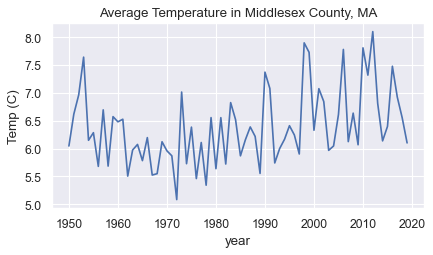

,Unnamed: 0,fips,year,prec,tAvg,tMax,tMin
1127,1127,23017,1950.0,0.261201,6.045459,12.384527,-0.293610
4164,4164,23017,1951.0,0.351008,6.617509,12.763306,0.471712
7201,7201,23017,1952.0,0.289846,6.964517,13.280014,0.649021
10238,10238,23017,1953.0,0.329602,7.642367,14.120450,1.164284
13275,13275,23017,1954.0,0.430148,6.147974,12.007143,0.288804


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/annual_weather.csv')
plt.figure(figsize=(6, 3), dpi=80)
subset = climate_df[climate_df.fips == 23017] # Only looking at Middlesex County
year = subset.year.values.reshape(-1,1)
temp = subset.tAvg.values.reshape(-1,1)

sns.lineplot(x='year', y='tAvg', data=subset)
# sns.lineplot(subset.year, subset.tAvg)  # this format is deprecated in python 3.11
plt.title("Average Temperature in Middlesex County, MA")
plt.ylabel('Temp (C)')
plt.show()
subset.head()

### Do we need to adjust scale? 
Can take log transformation, or other transformation, if data does not appear to have constant scale throughout. 

Does not appear to be relevant for this dataset. 


### Should we fit a linear trend? 

[[0.01144365]]


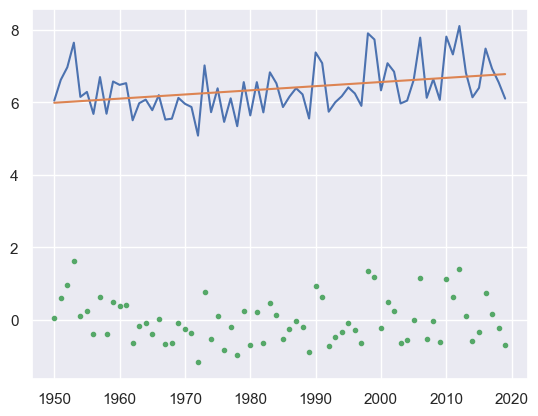

In [15]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(year, temp)
print(clf.coef_)
temp_hat = clf.predict(year)
linear_residuals = temp - clf.predict(year)
plt.plot(year, temp, label='original data')
plt.plot(year, temp_hat, label='fitted line')
plt.plot(year, linear_residuals, '.', label='residuals line')

### Fitting Seasonal Component

First, look if there is evidence of a seasonal component from the ACF/PACF plots.

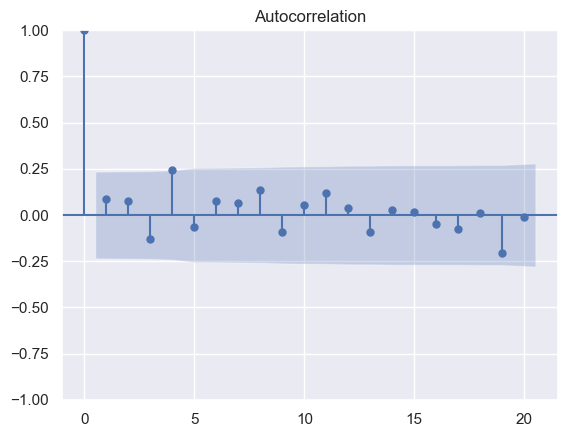

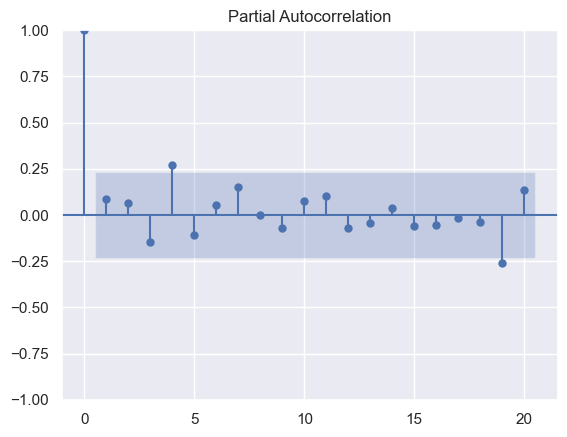

In [16]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(linear_residuals, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=20)
plt.show()

There is no convincing data to treat it as an ARMA model

### Removing Seasonal Component 
The first step is identifying the periodicity of the seasonal component, which we do by inspecting the time series and the ACF/PACF plots. 

After this stage, we present two methods to remove the seasonal component: by using a sinusoidal approximation to the seasonal component, and by fitting fixed-effects terms. 

Sinusoidal Approximation

Here, we use an optimization package to find the best sinusoidal approximation to this pattern. 

This assumes that the model has already been de-trended, and looks for the best fit model of the following form: 
$$ S_t = a + b \sin\left(\phi + \frac{t * 2 \pi }{period}\right)
$$
where $a$ is the mean of the sine function, $b$ is the amplitude, and $\phi$ is the phase shift. 
We assume that the period has already been determined, although it would be possible to use the optimizer to find this value as well. 

Note that here, we are estimating 3 variables (a, b, and $\phi$), so we are using 3 degrees of freedom. 

C:\Users\chito\AppData\Local\Temp\ipykernel_64520\2569392387.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = sine_curve_fit = optimize.curve_fit(f = sine_function, xdata = x_data.flatten(), ydata = y_data.flatten(), p0 = np.array([3, 1, 0]))


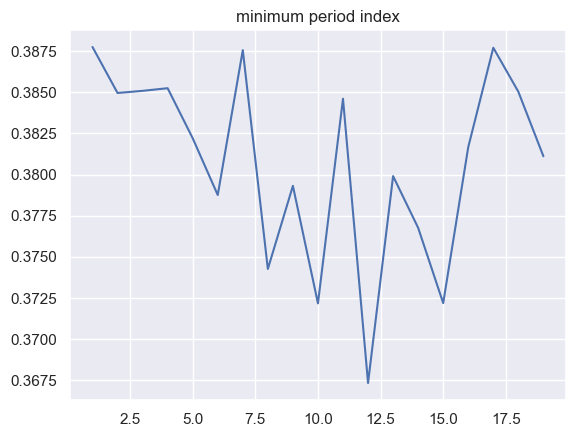

minimizing period is: 12


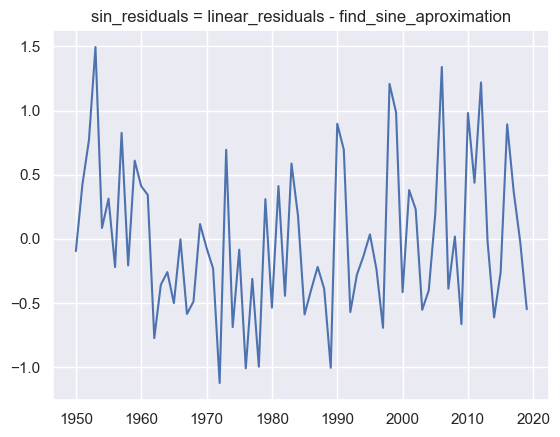

In [41]:
from scipy import optimize

period_range = np.arange(1, 20)
mse_list = []

def find_sine_approximation(period, x_data=year, y_data=temp):
    """
    Finds a best-fitting sinusoidal approximation, for the given period. 
    """
    def sine_function(X, amp, phase_shift, mean):
        return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
    params, _ = sine_curve_fit = optimize.curve_fit(f = sine_function, xdata = x_data.flatten(), ydata = y_data.flatten(), p0 = np.array([3, 1, 0]))
    amp, phase_shift, mean = params
    sin_prediction = sine_function(x_data, amp, phase_shift, mean)
    return sin_prediction

for period in period_range:
    sin_prediction = find_sine_approximation(period, year, linear_residuals)
    mse = np.nanmean((linear_residuals - sin_prediction) **2)
    mse_list.append(mse)

plt.plot(period_range, mse_list);
plt.title("minimum period index")
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)
sin_residuals = linear_residuals - find_sine_approximation(period_guess, year, linear_residuals)
plt.plot(year, sin_residuals)
plt.title("sin_residuals = linear_residuals - find_sine_aproximation")
plt.show()

### External Regressor: Consider El Nino index

El Nino index is from [here](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php); we use ONI (Oceanic el Nino Index), a measure of how anomalous warm or cool the central-to-eastern equatorial Pacific Ocean is compared to "normal".

I've aggregated this data to yearly values to standardize the comparison; this index is only available from 1950-2020.

This regressor is often correlated with global temperature patterns, so the test is for a correlation in this dataset. 

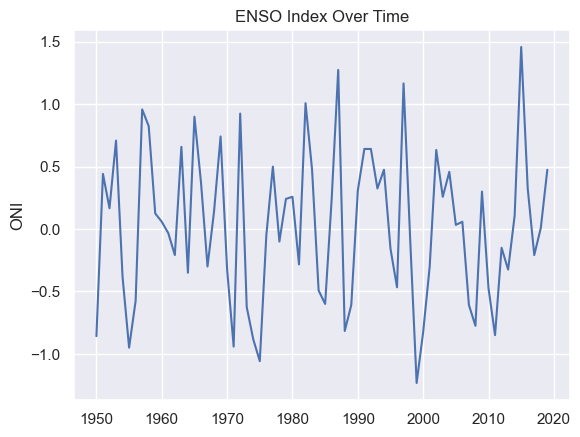

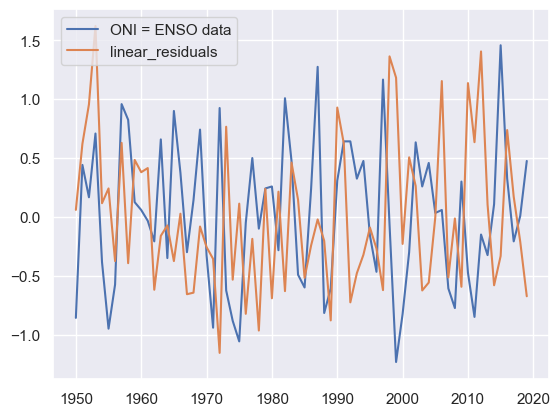

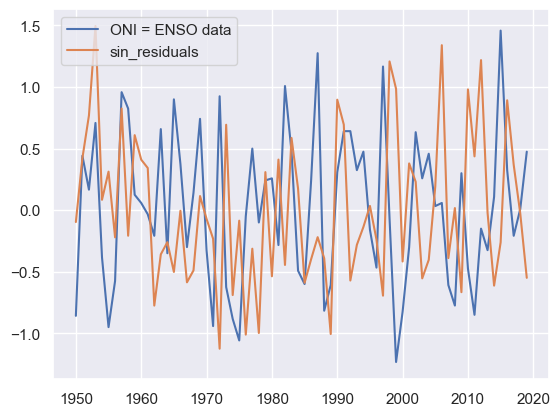

In [42]:
import pandas as pd
enso_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/enso_index.csv')
ONI = enso_df[enso_df.year.isin(climate_df.year)]['ONI_index'].values.reshape(-1,1)
plt.plot(year, ONI)
plt.title("ENSO Index Over Time")
plt.ylabel("ONI")
plt.show()
plt.plot(year, ONI, label='ONI = ENSO data')
plt.plot(year, linear_residuals, label='linear_residuals')
plt.legend()
plt.show()
plt.plot(year, ONI, label='ONI = ENSO data')
plt.plot(year, sin_residuals, label='sin_residuals')
plt.legend()
plt.show()

There is no coherent overlap thus a lack of correlation is expected.

SignificanceResult(statistic=np.float64(-0.12904975717128836), pvalue=np.float64(0.28699964373818654))

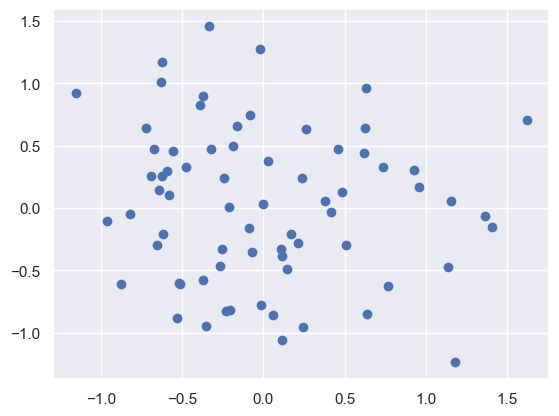

In [31]:
from scipy import stats
plt.scatter(linear_residuals, ONI)
stats.spearmanr(linear_residuals,ONI)

Observing this monotonic correlation results by scipy.stats.spearmanr, does not convince the inclusion of ONI = ENSO data in our model.
There is no monotonicity in the correlation, yielding:

statistic = np.float64(-0.12904975717128836), 
pvalue    = np.float64( 0.28699964373818654)

Because the sin_residuals have the similar pattern as linear_residuals, the same correlation result is expected.

A more rigorously test for a relationship between lagged values of the ENSO index and our temperature variable could work. Not attempted in this notebook. 

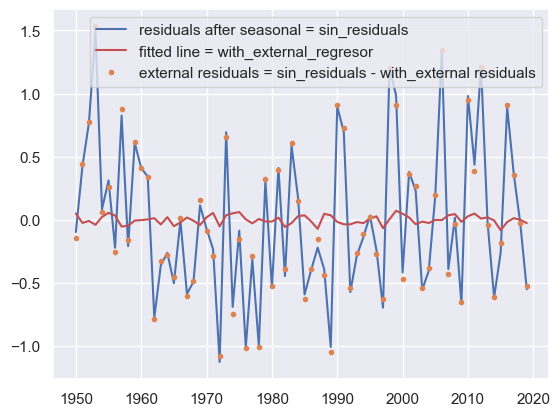

In [44]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(ONI, sin_residuals)
with_external_regressor = clf.predict(ONI)
external_residuals = sin_residuals - with_external_regressor
plt.plot(year, sin_residuals, label='residuals after seasonal = sin_residuals')
plt.plot(year, with_external_regressor, 'r', label='fitted line = with_external_regresor')
plt.plot(year, external_residuals,'.', label='external residuals = sin_residuals - with_external residuals');
plt.legend()

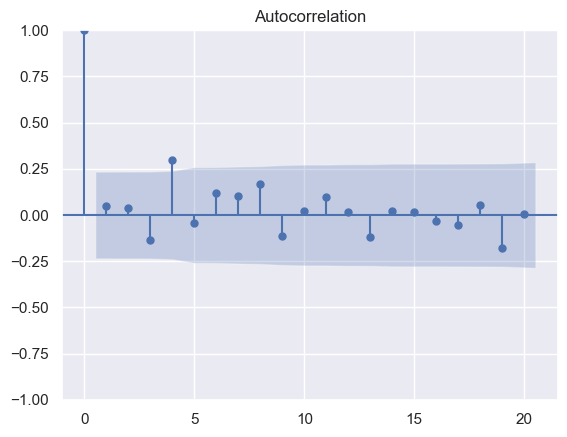

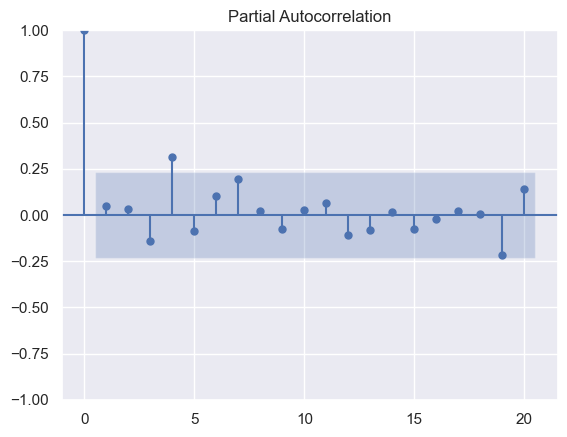

In [45]:
sm.graphics.tsa.plot_acf(external_residuals, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(external_residuals, lags=20)
plt.show()

### Model Selection
Here, we test each combination of models simultaneously. We select a model based on AIC and BIC. 

We automate a search over a range of potential values, and select the model with minimal AIC and BIC. 

In [61]:
period = 5
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.deterministic import DeterministicProcess

min_AIC = np.inf
min_BIC = np.inf
AIC_choice = None
BIC_choice = None

for period in [None] + [x for x in range(2, 13)]:
    for order in [0, 1]:
        for exog, exog_label in zip([ONI, None], ['ONI',None]):
            det_comp = DeterministicProcess(year.flatten(), period=period, constant=True,
                                      order=order, seasonal=period is not None)
            model = AutoReg(temp, exog=exog, deterministic=det_comp, lags=None, 
                      trend='n',seasonal=False).fit()
            # print("Model has period {}, order {}, exog {}".format(period, order, exog_label))
            # print("AIC", model.aic, "BIC", model.bic )
            # print("-"*20)
            if model.aic < min_AIC:
                AIC_choice = (period, order, exog_label)
                min_AIC = model.aic
            if model.bic < min_BIC:
                BIC_choice = (period, order, exog_label)
                min_BIC = model.bic 
print(AIC_choice, min_AIC)
print(BIC_choice, min_BIC)

(None, 1, None) 138.3348565493936
(None, 1, None) 145.08034227554168


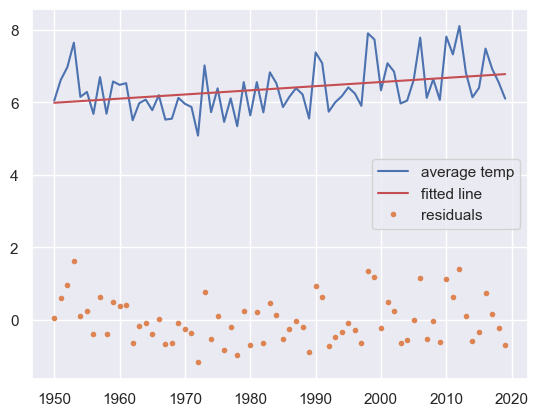

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   70
Model:                     AutoReg(0)   Log Likelihood                 -66.167
Method:               Conditional MLE   S.D. of innovations              0.623
Date:                Wed, 23 Jul 2025   AIC                            138.335
Time:                        13:20:27   BIC                            145.080
Sample:                             0   HQIC                           141.014
                                   70                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9746      0.150     39.708      0.000       5.680       6.270
trend          0.0114      0.004      3.107      0.002       0.004       0.019


In [51]:
period, order, exog = AIC_choice
det_comp = DeterministicProcess(year.flatten(), period=period, order=order, constant=True, seasonal =period is not None)
model = AutoReg(temp, exog=exog, deterministic=det_comp, lags=None, trend='n',seasonal=False).fit()
model_predictions = model.predict()
residuals = temp - model_predictions.reshape(-1,1)
plt.plot(year, temp, label='average temp')
plt.plot(year, model_predictions, 'r', label='fitted line')
plt.plot(year, residuals,'.', label='residuals');
plt.legend()
plt.show()
print(model.summary())

## Interpretation: 
* Our model fitting procedure selects a trend component 
* AIC and BIC agree on model selection
* From output of the model, trend has coefficient of 0.0114 with a p-value lower than 0.01. 
* Statistically significant climate change 

## Summary: Analysis Steps for Model Selection
1. Do we need to scale the data? 
2. Fit (non)linear trend to the data?
3. Fit seasonal components?
4. Fit external regressors? 
5. Fit AR/MA model? 
 